## Basic Ideas

* We want to emulate the output from one ensemble and one out-connection
* In a full simulation, output is computed by encoding and decoding the input for each neuron, which can be computationally expensive
* We try to characterize the actual output using a short simulation, and _emulate_ it in longer simulations 
 
 
## Surrogate Approach
[https://www.mitpressjournals.org/doi/full/10.1162/NECO_a_00734](https://www.mitpressjournals.org/doi/full/10.1162/NECO_a_00734) (by Prof. Bryan Tripp)   
The article is freely accessible on the UWaterloo eduroam network

* There is a difference between ideal and simulated outputs, given input `x` 
    * $e(x) = f_{simulated}(x) - f_{ideal}(x) $  
  
  
* We want to estimate $e(x)$ accurately and fast, so we can sum it with the ideal output (which usually computes faster than full simulation) to estimate the simulated output. Let $\widetilde{e}(x) \approx e(x)$
    * $f_{simulated}(x) \approx \widetilde{e}(x) + f_{ideal}(x)$
    
    
* According to the paper, the difference $e(x)$ can be broken into two componenents: the _bias_ term $b(x)$ and the _noise_ term $s(t)$. Note that bias is defined with respect `x`, but noise is defined with respect to time `t`. 
    * Bias represents the low frequency (smoother curves) component of $e(x)$. Concretely, it is the difference between the decoded output and the ideal output. 
    ```python
    # compute encoding and decoding at selected points
    _, encoded_rates = tuning_curves(ens, sim, inputs=eval_points) 
    static_output = np.dot(encoded_rates, sim.data[out_conn].weights.T) 
    # compute ideal output
    ideal_output = np.apply_along_axis(function, 1, eval_points)
    # compute difference
    bias =  static_output - ideal_output
    ```
    
    * Noise represents the high frequency components of $e(x)$. Concretely, it is the difference between the actual output of a simulation and the statically decoded output. NOTE: we must run the full simulatoin for a short period to obtain noise samples
    ```python
    # compute encoding and decoding statically
    _, encoded_rates = tuning_curves(ens, sim, inputs=eval_points)
    static_output = np.dot(encoded_rates, sim.data[out_conn].weights.T)
    # compute difference between actual output
    noise = actual_output - static_output
    ```

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


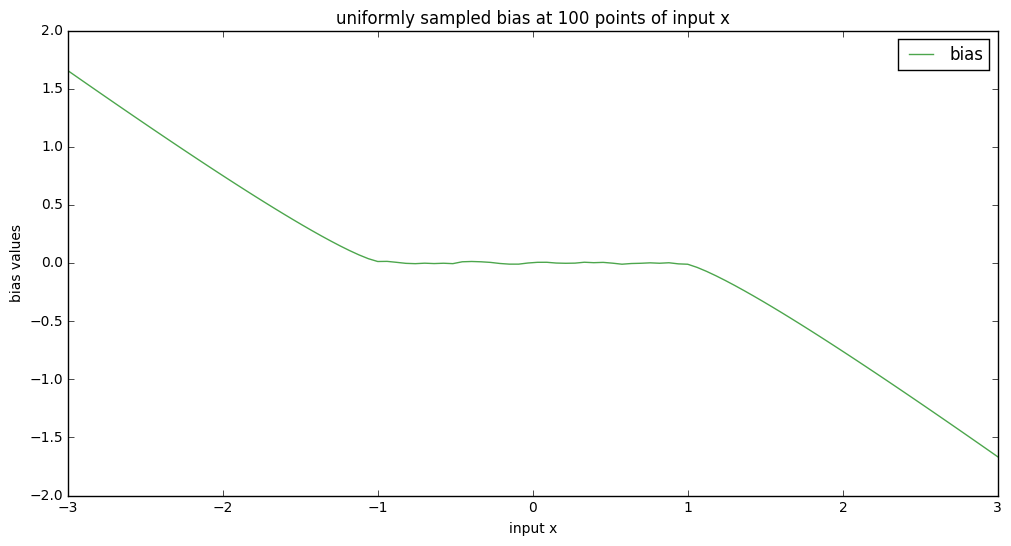

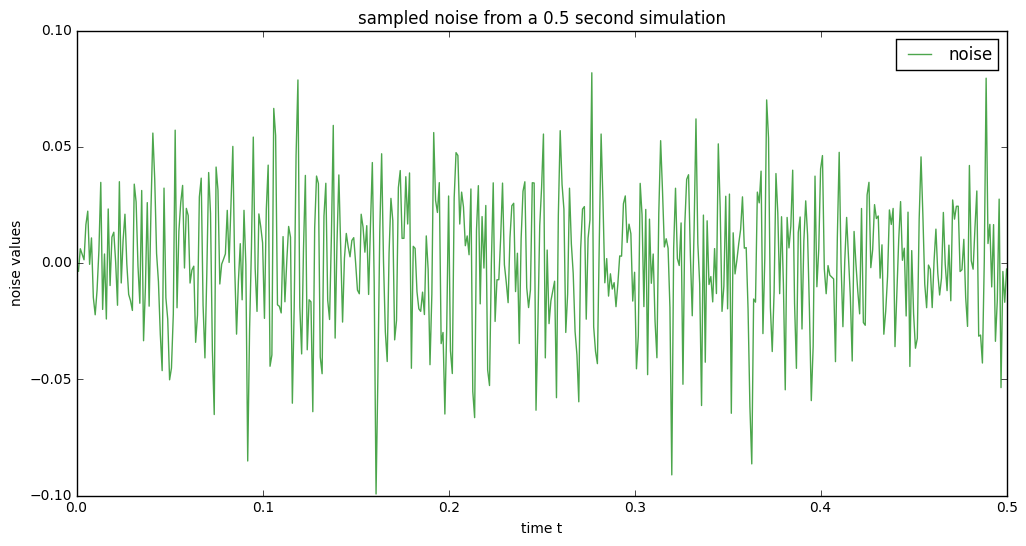

In [2]:
%matplotlib inline

import numpy as np
import nengo
from surrogate import SurrogateEnsemble, Mapping
import matplotlib.pyplot as plt
import scipy
import math

ensemble_config = {
    'n_neurons': 100,
    'dimensions': 1
}

def function(x):
    return x

lin_components = [
    Mapping(function, 1, 1, [0], [0]),
]

connection = nengo.Connection(
    nengo.Node([1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

surrogate = SurrogateEnsemble(ensemble_config, connection, lin_components, dt=0.001)
surrogate.build(seed=6)

plt.figure(figsize=(12,6))
plt.title("uniformly sampled bias at 100 points of input x")
plt.xlabel('input x')
plt.ylabel('bias values')
plt.plot(surrogate.bias_eval_points[:,0], surrogate.sampled_bias[:,0], 'g', label="bias", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title("sampled noise from a 0.5 second simulation")
plt.xlabel('time t')
plt.ylabel('noise values')
plt.plot(surrogate.training_tranges[0], surrogate.training_sim_noises[0][:,0], 'g', label="noise", alpha=0.7)
plt.legend()

## Operational Steps

1. Build network and sample bias values
2. Interpolate on the sampled bias values to estimate the bias function
3. Run a short simulation and extract noise samples
4. Build a statistical model that matches the noise 
5. Combine them with the ideal output to emulate the actual output given inputs


### Bias Estimation

* Simple when the input (= ensemble dimension) is 1D. We interpolate on the sample bias using linear, quadratic or cubic splines. 
    * Spline interpolation basically means we build piecewise functions (which are either linear, quadratic or cubic) between sample points, and the piecewise functions must match with each other at the sample points, in terms of value, and first and second derivatives, etc.
    
```python
grid_points = self._generate_eval_points(ens.radius, mapping)
sampled_bias = self._calc_bias(sim, ens, eval_points, out_conn, mapping.function)
bias_function = interp1d(grid_points.ravel(), sampled_bias, kind=interporlation)
```

* We chose linear as the default because it had slightly lower root-mean-square errors when the number of interpolation points is low. 


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


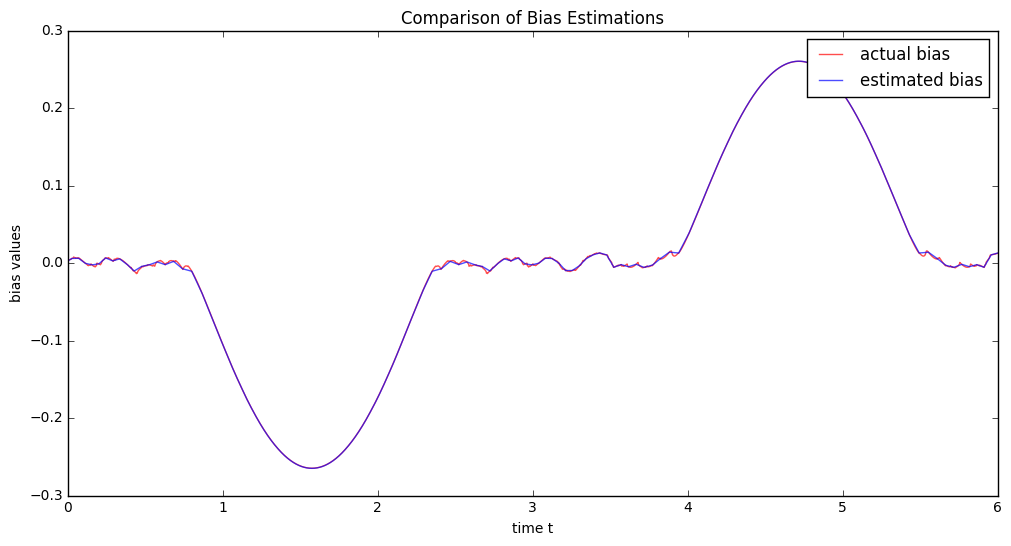

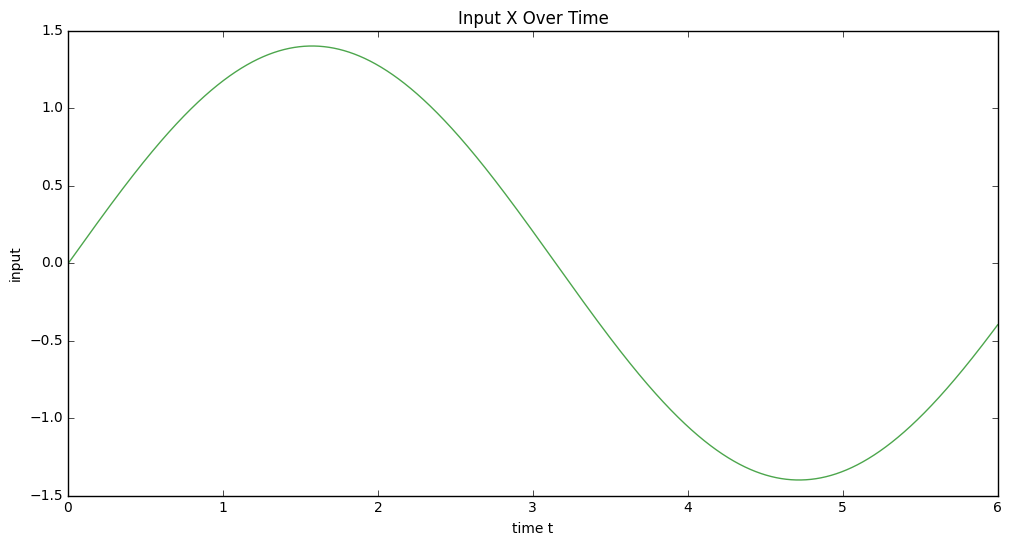

In [3]:
def input_func(t):
    return 1.4*math.sin(t)

surrogate.test_performance(input_func, length=6, seed=6)


plt.figure(figsize=(12,6))
plt.title('Comparison of Bias Estimations')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_bias_values[:,0], 'r', label="actual bias", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_bias_values[:,0], 'b', label="estimated bias", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('Input X Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="Input", alpha=0.7)

We see that the bias outside of ensemble radius is accurately modeled

### Noise Modeling

* ARMA model 
    * $ X_t = c + \epsilon_t + \sum_{i=1}^{p} a_i X_{t-i} + \sum_{i=1}^{q} b_i \epsilon_{t-i}$
    * The signal has an average value, but output at each time step deviates from the average by a Gaussian noise as well as patterns determined by values from previous time steps. 
    * $c$ is the average of the noise - assumed to 0
    * The $ε_t$ parameter is a Gaussian noise generated at each time step. Mean is assumed to zero, and variance is a parameter
    * $a_i$’s and $b_i$'s are parameters that define the ways in which each output value depends on previous ones


* We solve for optimal parameters that fit the noise sample
* p and q are both chosen to 2 - models with larger p and q capture broder classes of noise but solving for more parameters is more costly

```python
model = ARMA(noise, order=(2,2)).fit([0,0,0,0], trend='nc', disp=False)
generated_noise = arma_generate_sample(
    ar=np.r_[1, -model.arparams],  # pad 1 because i starts from 0 in this method
    ma=np.r_[1, model.maparams],
    nsample=100,
    sigma=model.sigma2**0.5  # the variance of the Gaussian noise epsilon
)
```

* We fit parameters to a 0.5 second noise sample, and generate noise using the parameters 

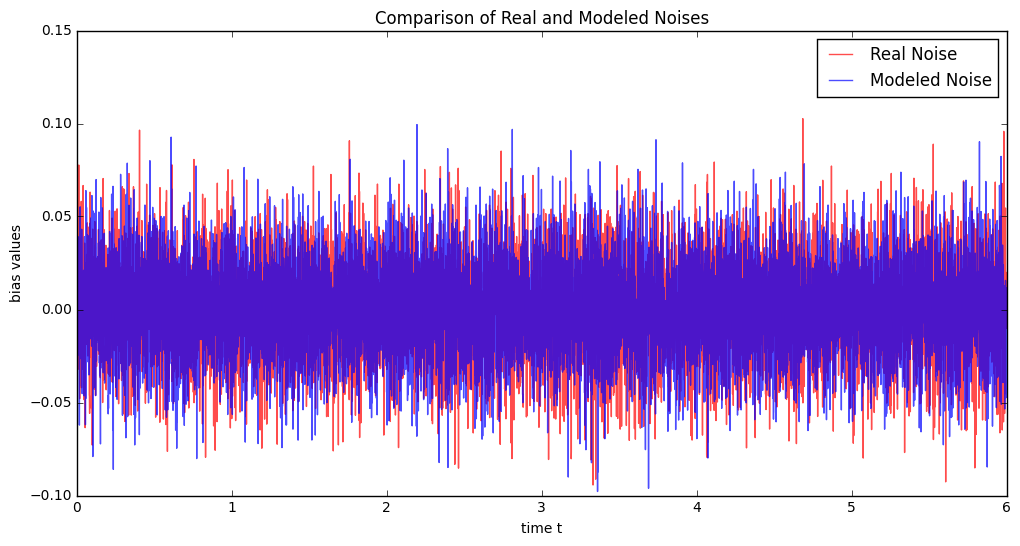

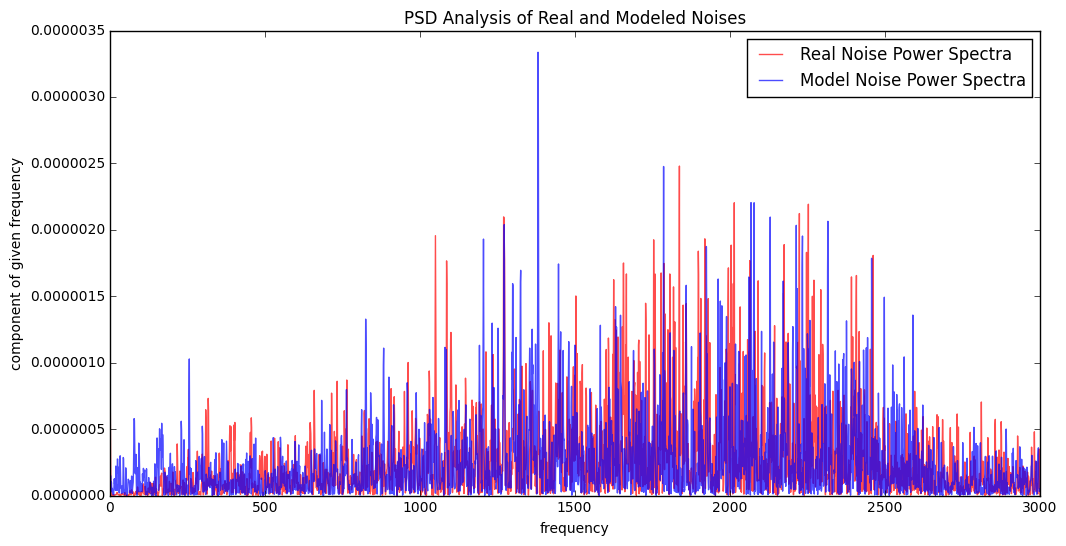

In [4]:
plt.figure(figsize=(12,6))
plt.title('Comparison of Real and Modeled Noises')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_noise_values[:,0], 'r', label="Real Noise", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_noise_values[:,0], 'b', label="Modeled Noise", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('PSD Analysis of Real and Modeled Noises')
plt.xlabel('frequency')
plt.ylabel('component of given frequency')
plt.plot(surrogate.spike_freqs[0], surrogate.spike_PSDs[0], 'r', label="Real Noise Power Spectra", alpha=0.7)
plt.plot(surrogate.model_freqs[0], surrogate.model_PSDs[0], 'b', label="Model Noise Power Spectra", alpha=0.7)
plt.legend()

## Putting it together

Given inputs, we compute the ideal output and bias values, and generate noise values. We then sum them together 

```python
ideal_output = np.apply_along_axis(function, 1, inp)
bias_values = bias_model.eval(inp)
noise_values = noise_model.generate_noise()

output = ideal_output + bias_values + noise_values
return output
```

### Performance

* As shown below, building the population mode takes longer time (since a short simulation must be run), but emulating the output, after bias and noise models are built, is very fast 
    * Scales well for longer simulations

In [5]:
import time 


ensemble_config = {
    'n_neurons': 100,
    'dimensions': 1
}

def function(x):
    return x

lin_components = [
    Mapping(function, 1, 1, [0], [0]),
]

connection = nengo.Connection(
    nengo.Node([1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

def input_func(t):
    return 1.4*math.sin(t)

surrogate = SurrogateEnsemble(ensemble_config, connection, lin_components, dt=0.001)

start = time.time()
sim, ens, out_conn, p_in, p_out = surrogate.build_network(
    input_func, surrogate.connection, surrogate.connection.function, 
    surrogate.connection.transform, surrogate.dt, 6
)
end = time.time()
full_simulation_build_time = end-start
print "==================="
print "full simulation build time: ", full_simulation_build_time
print "==================="

start = time.time()
surrogate.build(noise_sampling_steps=1, seed=6)
end = time.time()
population_mode_build_time = end-start
print "==================="
print "population mode build time:", population_mode_build_time
print "==================="


for i in [3,5,7,9]:
    print "\n==================="
    print "Simulation length = %d seconds" % i
    print "==================="
    
    start = time.time()
    sim.run(i)
    end = time.time()
    full_simulation_length = end - start
    print "\nfull simulation took: ", full_simulation_length
    print "Overall (build+simulation) time took: ", full_simulation_length + full_simulation_build_time

        
    out_shape = sim.data[p_out].shape
    start = time.time()
    surrogate.emulate(sim.data[p_in], out_shape)
    end = time.time()
    poplation_mode_simulation_length = end - start
    print "\npopulation mode simulation took: ", poplation_mode_simulation_length
    print "Overall (build+simulation) time took: ", poplation_mode_simulation_length + population_mode_build_time


Building finished in 0:00:01.                                                   
full simulation build time:  0.0488569736481
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
population mode build time: 0.364132881165

Simulation length = 3 seconds
Simulating finished in 0:00:01.                                                 

full simulation took:  0.741099119186
Overall (build+simulation) time took:  0.789956092834

population mode simulation took:  0.0105268955231
Overall (build+simulation) time took:  0.374659776688

Simulation length = 5 seconds
Simulating finished in 0:00:02.                                                 

full simulation took:  1.38085699081
Overall (build+simulation) time took:  1.42971396446

population mode simulation took:  0.0320670604706
Overall (build+simulatio

### Accuracy

* Below are plots of ideal, actual and emulated outputs.  
    * We see that saturation behaviour is modeled well.

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


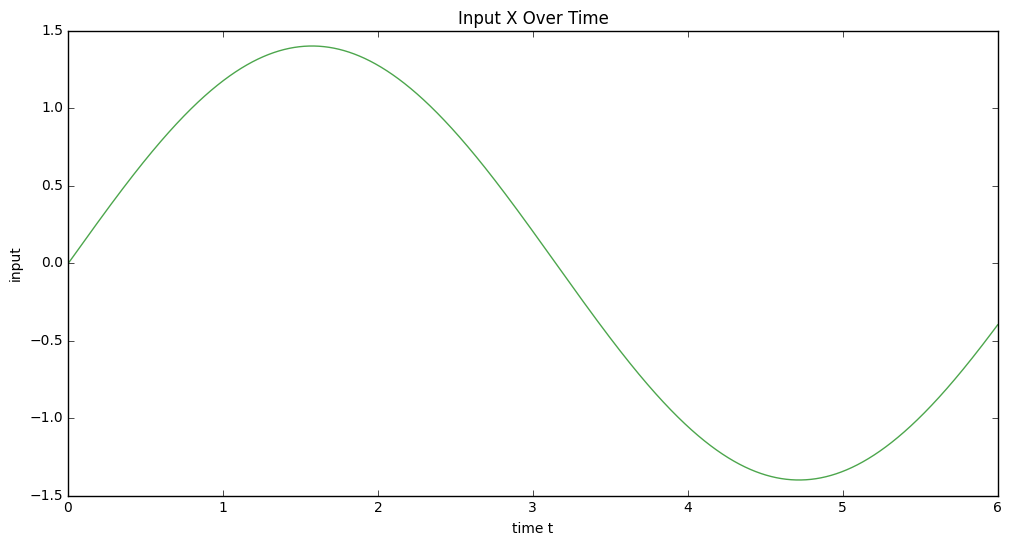

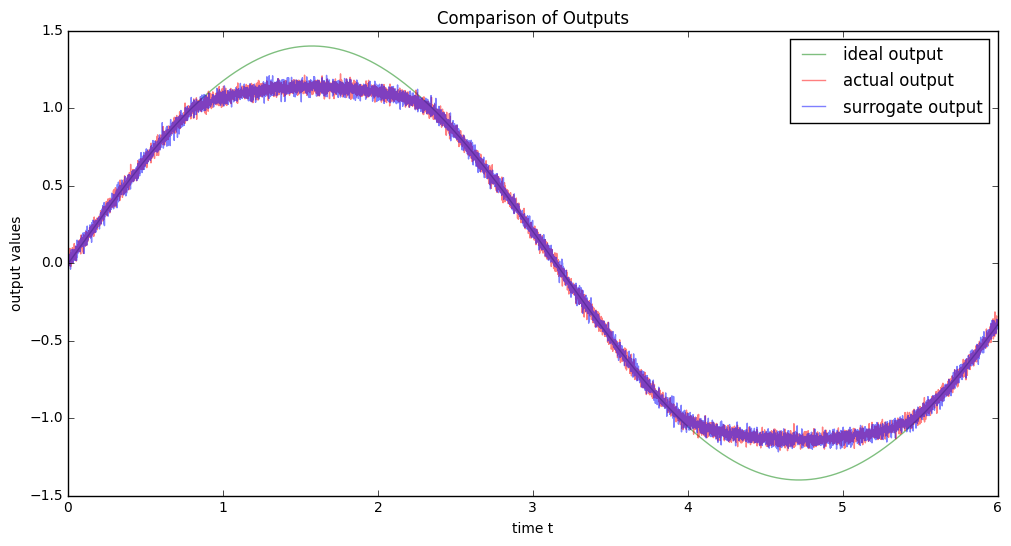

In [6]:
surrogate = SurrogateEnsemble(ensemble_config, connection, lin_components, dt=0.001)
surrogate.build(noise_sampling_steps=1, seed=6)
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Input X Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="Input", alpha=0.7)

plt.figure(figsize=(12,6))
plt.title("Comparison of Outputs")
plt.xlabel('time t')
plt.ylabel('output values')
plt.plot(surrogate.trange, surrogate.ideal_output[:,0], 'g', label="ideal output", alpha=0.5)
plt.plot(surrogate.trange, surrogate.actual_output[:,0], 'r', label="actual output", alpha=0.5)
plt.plot(surrogate.trange, surrogate.surrogate_output[:,0], 'b', label="surrogate output", alpha=0.5)
plt.legend()

## Bias in Higher Dimensions

* There are exponentially many points to interpolate when the input has more dimensions. i.e. With a 2D ensemble, if we choose 100 points per dimension, we need $100^2$ points to cover the whole grid
* This works okay for 2D, or even 3D ensembles

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


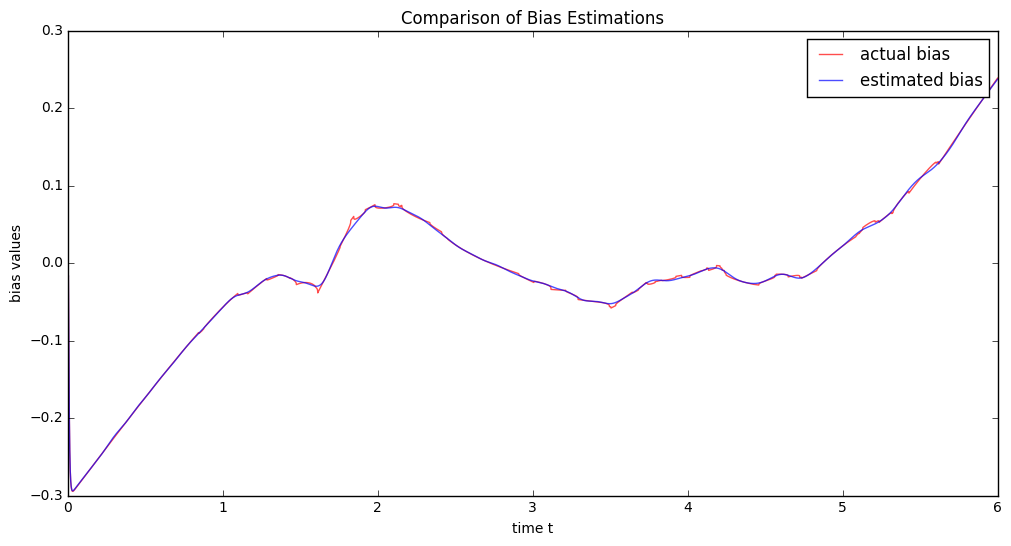

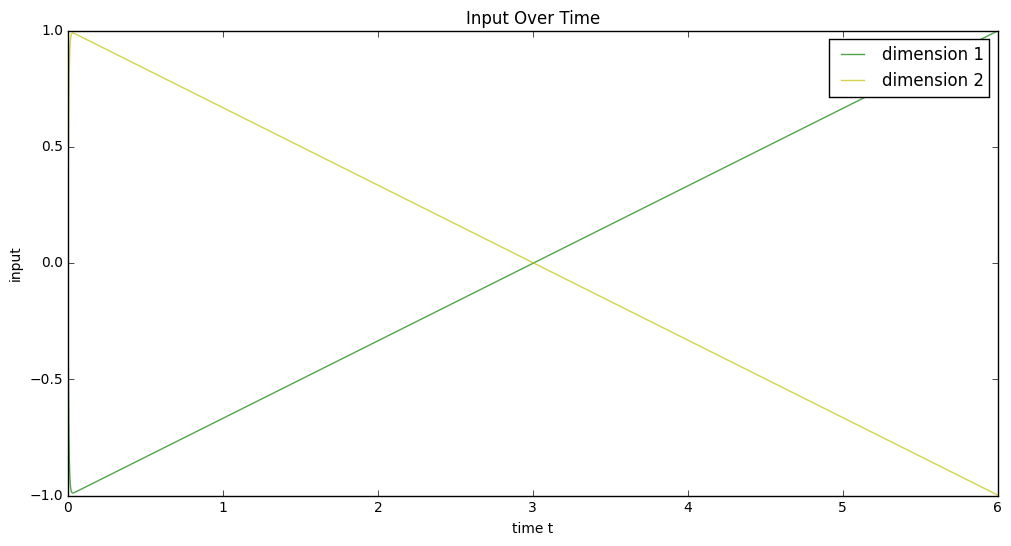

In [7]:
ensemble_config = {
    'n_neurons': 100,
    'dimensions': 2
}

def function(x):
    return x[0]*1 + x[1]*2

lin_components = [
    Mapping(function, 2, 1, [0,1], [0]),
]

connection = nengo.Connection(
    nengo.Node([1,1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

def input_func(t):
    return [-1 + t*2/6.0, 1 - t*2/6.0]


surrogate = SurrogateEnsemble(ensemble_config, connection, lin_components, dt=0.001)
surrogate.build(noise_sampling_steps=1, seed=6)
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Bias Estimations')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_bias_values[:,0], 'r', label="actual bias", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_bias_values[:,0], 'b', label="estimated bias", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="dimension 1", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,1], 'y', label="dimension 2", alpha=0.7)
plt.legend()

However, the native approach does NOT scale well for higher dimensions. i.e. $100^{20} \approx \infty$

#### Solution 
* As pointed out by the original paper, bias heavily depends on the _primary dimensions_ of a function
    * i.e. $f(x_1, x_2....x_n) = x_1$ has primary dimension 1
    * Bias values depend the most on dimension 1, and less on the rest. _This is generally true for bias pattern outside of the radius range_. For the small biases within the radius range, this is not as clear, as we'll see below.
    
    
* We can project all other dimensions (referred to as `secondary_dimensions` in the code) into one by taking their norm. $\widetilde{x}_2 = ||(x_2, x_3 .... x_n)||$
* We then just need 2D interpolation on $x_1$ and $\widetilde{x}_2$.

#### Generalizing the solution
* (It seems that) many functions used in modeling can be deconstructed into sub functions with a few primary dimensions. 
    * i.e. $f(x) = x \cdot [1,2,3]^T = (x_1 * 1) + (x_2 * 2) + (x_3 * 3)$
    * Since solving for decoder is linear, calculating bias for each sub function and summing them back together give the bias for the original function perfectly. This has been confirmed by experiments with fixed the seed between decoder solving.
    
    
* The problem is in using the primary dimension and projection of secondary dimensions to estimate the bias. Works okay for estimating the general bias pattern outside of the radius range, but not great for small biases within the radius 

#### Example 1

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


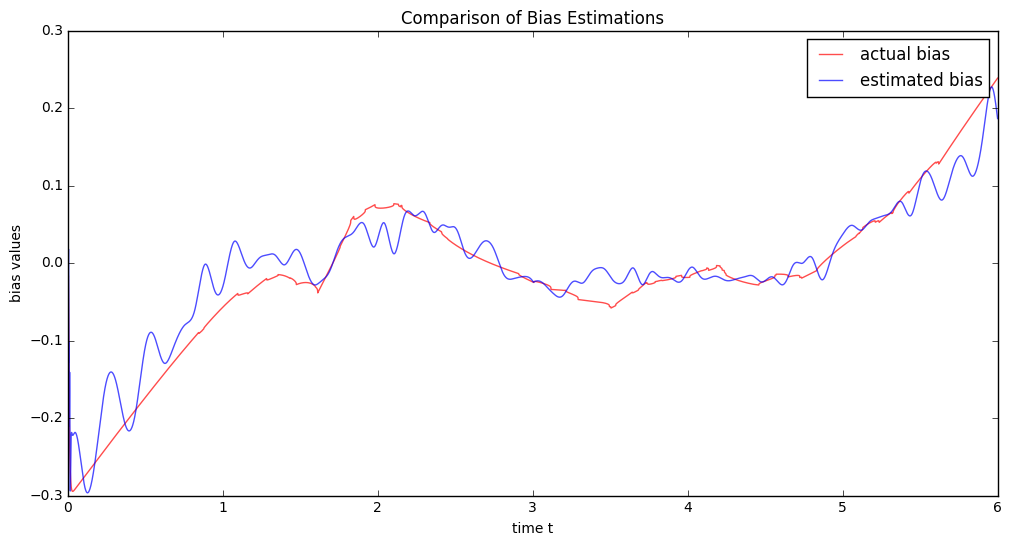

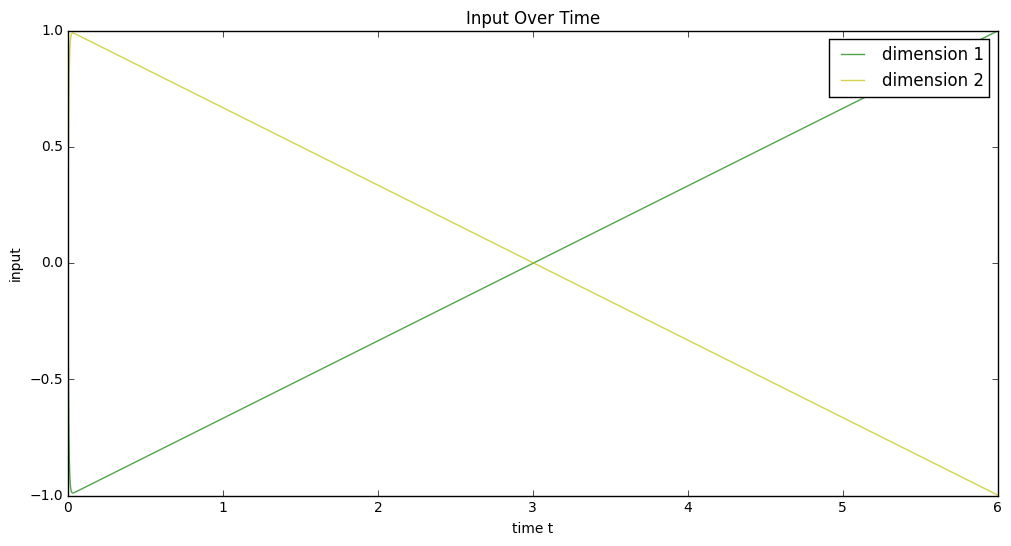

In [8]:
def function(x):
    return x[0]*1 + x[1]*2

components = [
    Mapping(lambda x: x[0]*1, 2, 1, [0], [0]),
    Mapping(lambda x: x[1]*2, 2, 1, [1], [0])
]

def input_func(t):
    return [-1 + t*2/6.0, 1 - t*2/6.0]

surrogate = SurrogateEnsemble(ensemble_config, connection, components, dt=0.001)
surrogate.build(noise_sampling_steps=1, seed=6)
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Bias Estimations')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_bias_values[:,0], 'r', label="actual bias", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_bias_values[:,0], 'b', label="estimated bias", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="dimension 1", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,1], 'y', label="dimension 2", alpha=0.7)
plt.legend()

#### Example 2

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


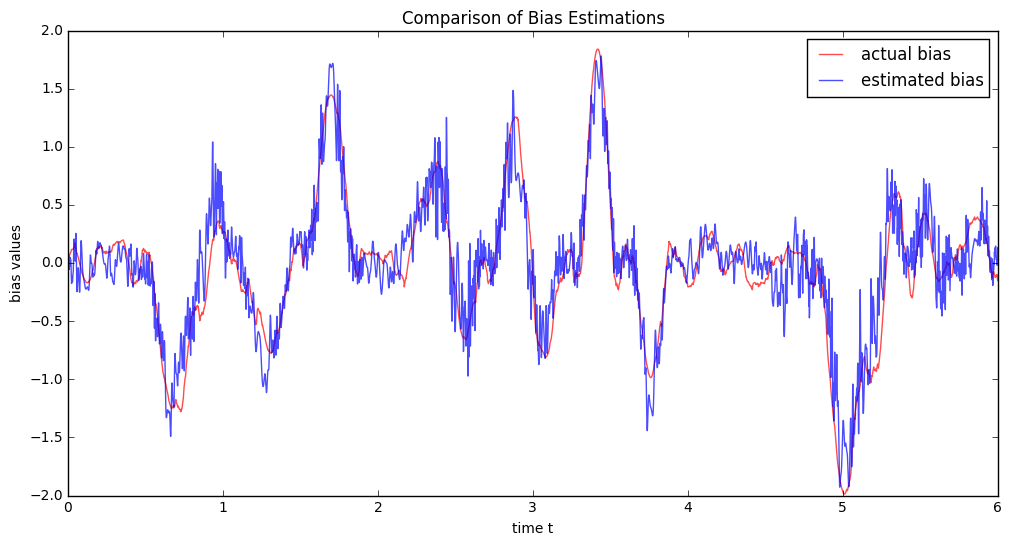

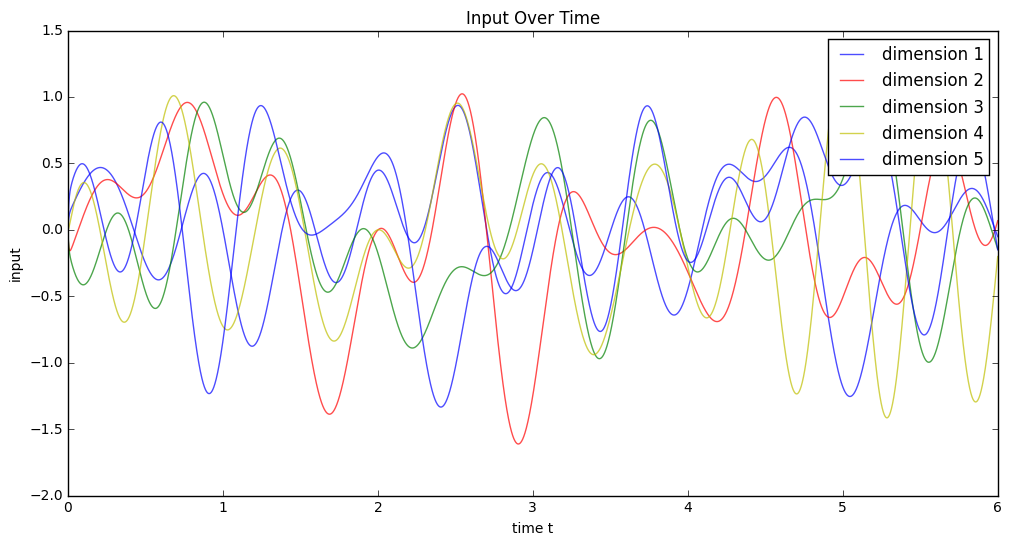

In [9]:
ensemble_config = {
    'n_neurons': 200,
    'dimensions': 5
}

def function(x):
    return x[0]*1 + x[1]*2 + x[2]*3 + x[3]*4 + x[4]*5

components = [
    Mapping(lambda x: x[0]*1, 5, 1, [0], [0]),
    Mapping(lambda x: x[1]*2, 5, 1, [1], [0]),
    Mapping(lambda x: x[2]*3, 5, 1, [2], [0]),
    Mapping(lambda x: x[3]*4, 5, 1, [3], [0]),
    Mapping(lambda x: x[4]*5, 5, 1, [4], [0])
]

connection = nengo.Connection(
    nengo.Node([1,1,1,1,1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

input_func = nengo.processes.WhiteSignal(10, 2, rms=0.5)

surrogate = SurrogateEnsemble(ensemble_config, connection, components, dt=0.001)
surrogate.build(noise_sampling_steps=1, seed=6)
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Bias Estimations')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_bias_values[:,0], 'r', label="actual bias", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_bias_values[:,0], 'b', label="estimated bias", alpha=0.7)
plt.legend()


plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'b', label="dimension 1", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,1], 'r', label="dimension 2", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,2], 'g', label="dimension 3", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,3], 'y', label="dimension 4", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,4], 'b', label="dimension 5", alpha=0.7)
plt.legend()


#### Example 3

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


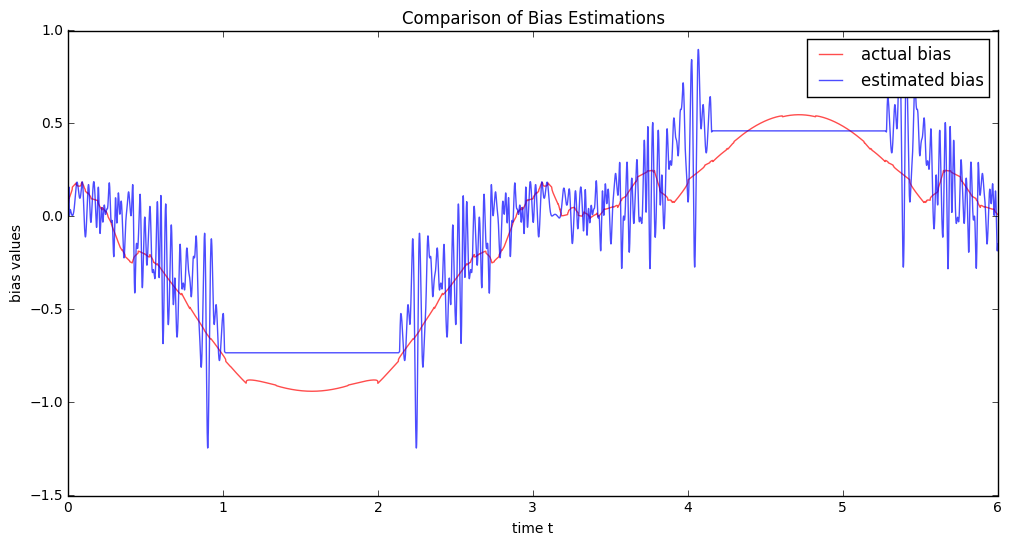

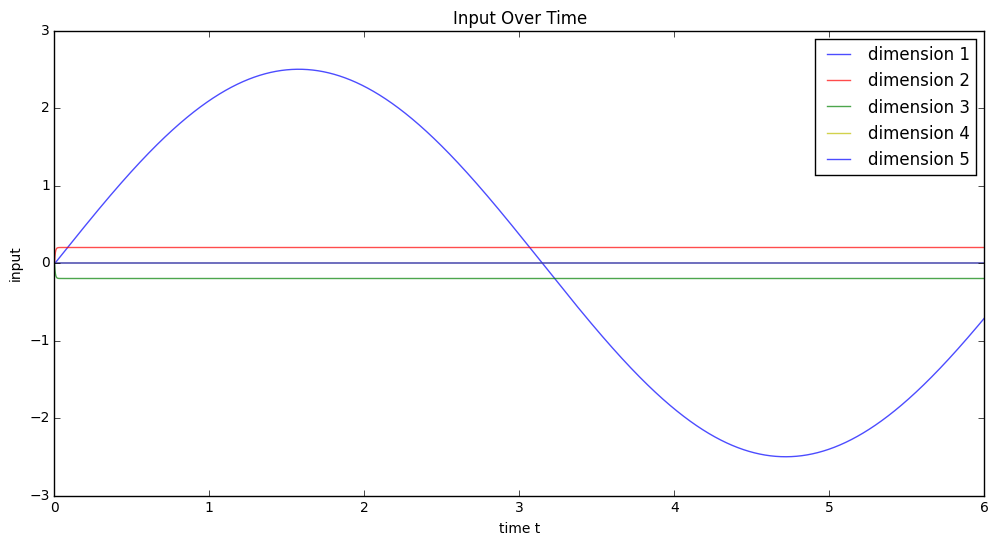

In [10]:
def input_func(t):
    return [2.5*math.sin(t),0.2,-0.2,0,0]

surrogate = SurrogateEnsemble(ensemble_config, connection, components, dt=0.001)
surrogate.build(noise_sampling_steps=1, seed=6)
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Bias Estimations')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_bias_values[:,0], 'r', label="actual bias", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_bias_values[:,0], 'b', label="estimated bias", alpha=0.7)
plt.legend()


plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'b', label="dimension 1", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,1], 'r', label="dimension 2", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,2], 'g', label="dimension 3", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,3], 'y', label="dimension 4", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,4], 'b', label="dimension 5", alpha=0.7)
plt.legend()

Increasing or decresing the number of interpolation points don't help...

## Precise Noise Modeling

* The noise component gets complicated when the desired function is __nonlinear__
    * i.e. for $f_{ideal}(x) = x^2$, the noise value at each step seems to depend on the input. For multi dimensional input, the noise depends on the absolute value of the input
    * In the ARMA model, noise at each step only depends on a Gaussian variable and previous steps. It does not consider the input value x into the ensemble

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


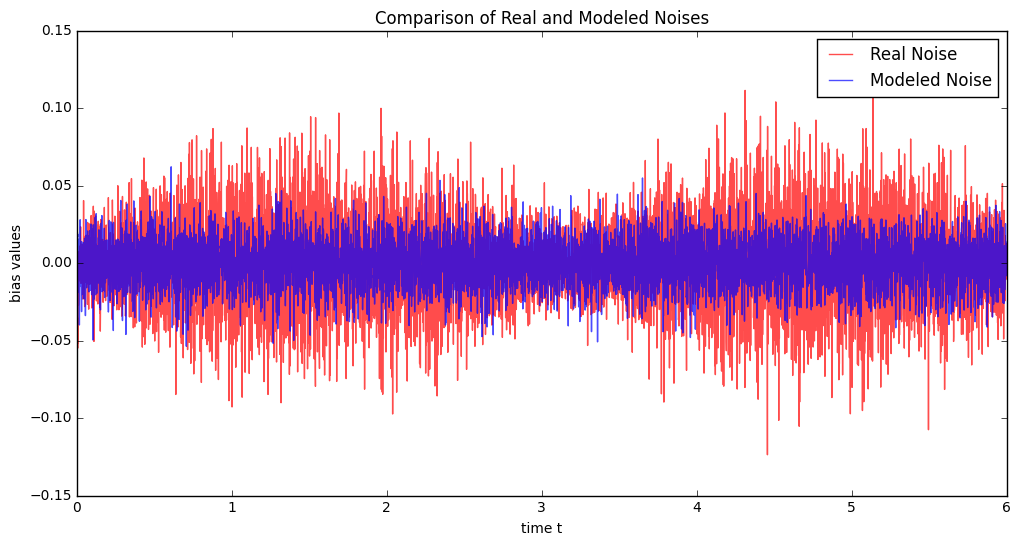

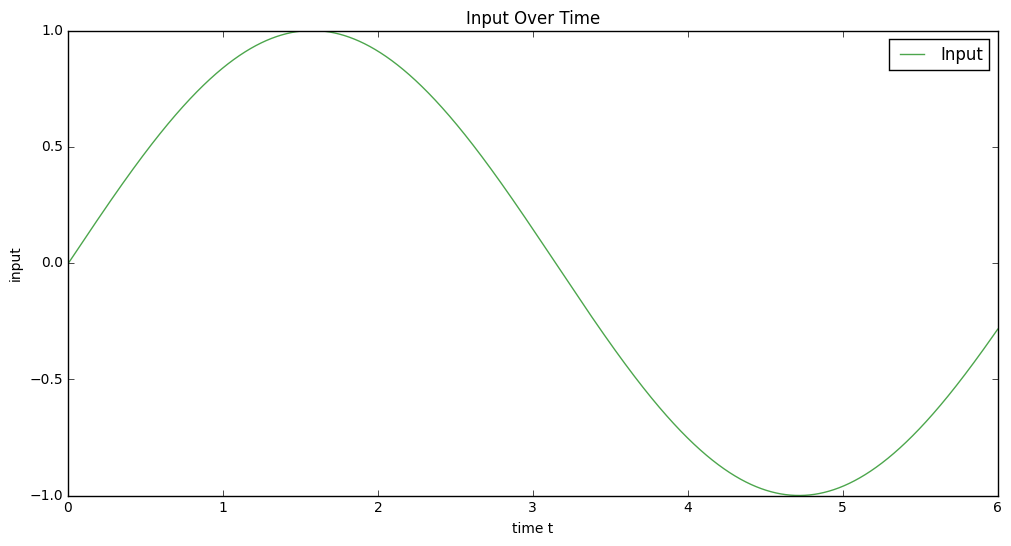

In [11]:
ensemble_config = {
    'n_neurons': 100,
    'dimensions': 1
}

def function(x):
    return x**2

lin_components = [
    Mapping(function, 1, 1, [0], [0]),
]

connection = nengo.Connection(
    nengo.Node([1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

def input_func(t):
    return math.sin(t)

surrogate = SurrogateEnsemble(ensemble_config, connection, lin_components, dt=0.001)
surrogate.build(noise_sampling_steps=1, seed=6)
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Real and Modeled Noises')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_noise_values[:,0], 'r', label="Real Noise", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_noise_values[:,0], 'b', label="Modeled Noise", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="Input", alpha=0.7)
plt.legend()


#### Solution
* We sample noises at different input ranges (we take the absolute value of the input for multi dimensional case), and build model for each input range. 
    * i.e. For 1D input, we can sample noises around 0, 1.0 and 2.0. For 3D input, we can sample noises with input with absolute values at around 0, 1.0, 2.0 
    
    
* When generating noise, we first calculate the absolute value of input at each step, and find models built at similar ranges. We then compute **weighted sum** of the two noises (as suggested by paper) 
    * i.e. If input at a time step is $[0.5, 0.5, 0.1]$, since $||[0.5, 0.5, 0.1]|| \approx 0.7$, we take the weighted sum of noise models built at 0 and 1.0
    * $w_0 = (1-0.7)/1.0 = 0.3$, $w_1 = (0.7-0)/1.0 = 0.7$. 
    * Let $s_0$ be noise generated by model built at 0.0, $s_1$at 1.0. $\sigma_0$ is the variance of noise at 0.0, $\sigma_1$ at 1.0. $s_t$ is the noise at time step $t$. Then:  
        $s_t = (w_0s_0 + w_1s_1) * (w_0\sigma_0 + w_1\sigma_1)(w_0^2\sigma_0^2 + w_1^2\sigma_1^2)^{-0.5}$
    * We multiply the weighted sum by a scalar factor, since summing two noises "cancel out" each other. 
        * Proof:  
    $Var(cx) = c^2Var(x)$ where c is a constant  
    => $Var(s_t) = (w_0\sigma_0 + w_1\sigma_1)^2(w_0^2\sigma_0^2 + w_1^2\sigma_1^2)^{-1} * Var(w_0s_0 + w_1s_1)$   
    => $Var(s_t) = (w_0\sigma_0 + w_1\sigma_1)^2(w_0^2\sigma_0^2 + w_1^2\sigma_1^2)^{-1} * (w_0^2s_0^2 + w_1^2s_1^2)$  
    => $Var(s_t) = (w_0\sigma_0 + w_1\sigma_1)^2$  
    Thus, standard deviation is the weighted sum of the standard deviations of the two noises

#### Example 1
1D ensemble, 100 neurons, $f_ideal(x) = x^2$, input = $sin(t)$

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


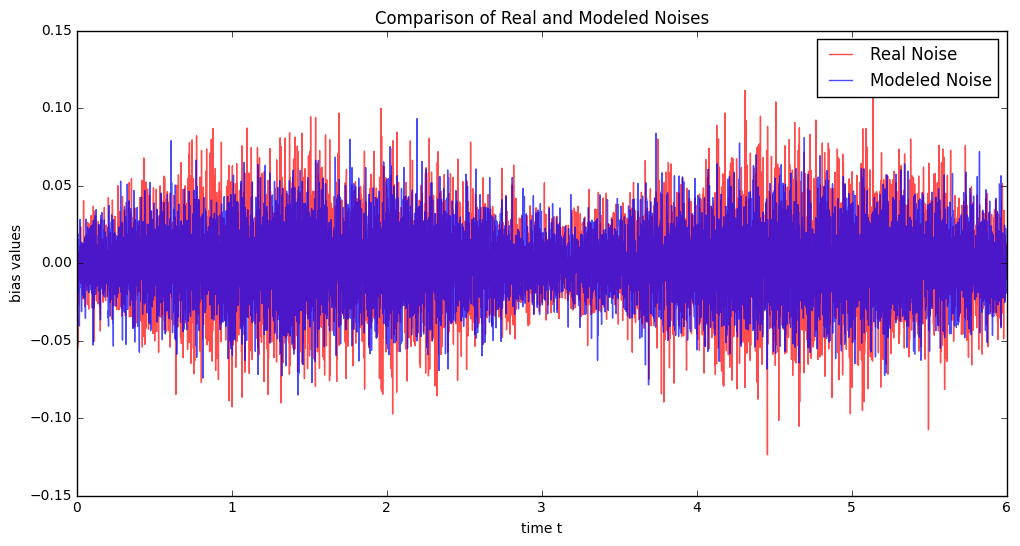

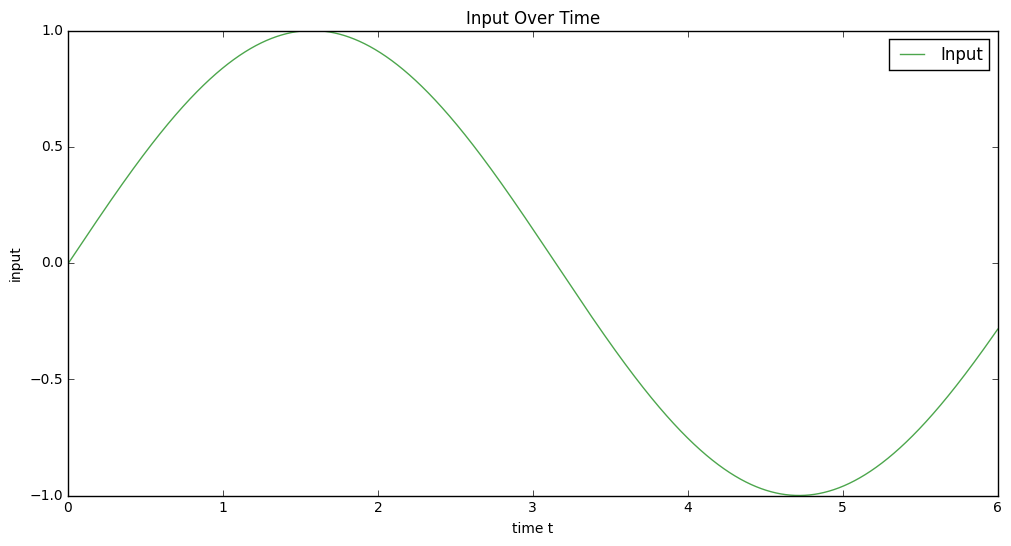

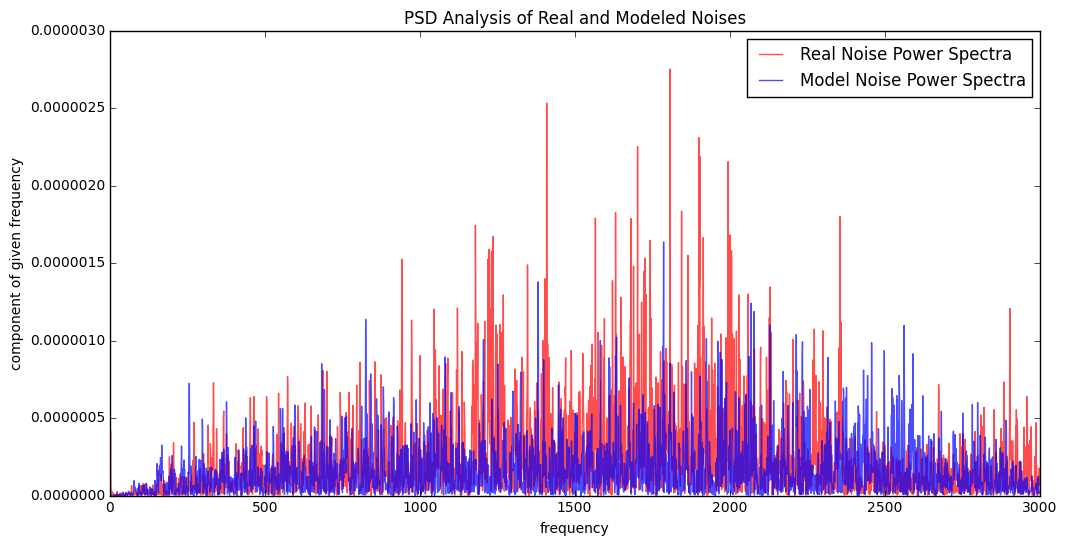

In [12]:
ensemble_config = {
    'n_neurons': 100,
    'dimensions': 1
}

def function(x):
    return x**2

lin_components = [
    Mapping(function, 1, 1, [0], [0]),
]

connection = nengo.Connection(
    nengo.Node([1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

surrogate = SurrogateEnsemble(ensemble_config, connection, lin_components, dt=0.001)

def input_func(t):
    return math.sin(t)

surrogate.build(noise_sampling_steps=3, seed=6) # sample noises at three input ranges
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Real and Modeled Noises')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_noise_values[:,0], 'r', label="Real Noise", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_noise_values[:,0], 'b', label="Modeled Noise", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="Input", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('PSD Analysis of Real and Modeled Noises')
plt.xlabel('frequency')
plt.ylabel('component of given frequency')
plt.plot(surrogate.spike_freqs[0], surrogate.spike_PSDs[0], 'r', label="Real Noise Power Spectra", alpha=0.7)
plt.plot(surrogate.model_freqs[0], surrogate.model_PSDs[0], 'b', label="Model Noise Power Spectra", alpha=0.7)
plt.legend()

#### Example 2
3D ensemble, 200 neurons, $f_ideal(x) = x_1^3 + x_2 + x_3^2$

Building finished in 0:00:02.                                                   
Building finished in 0:00:01.                                                   


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


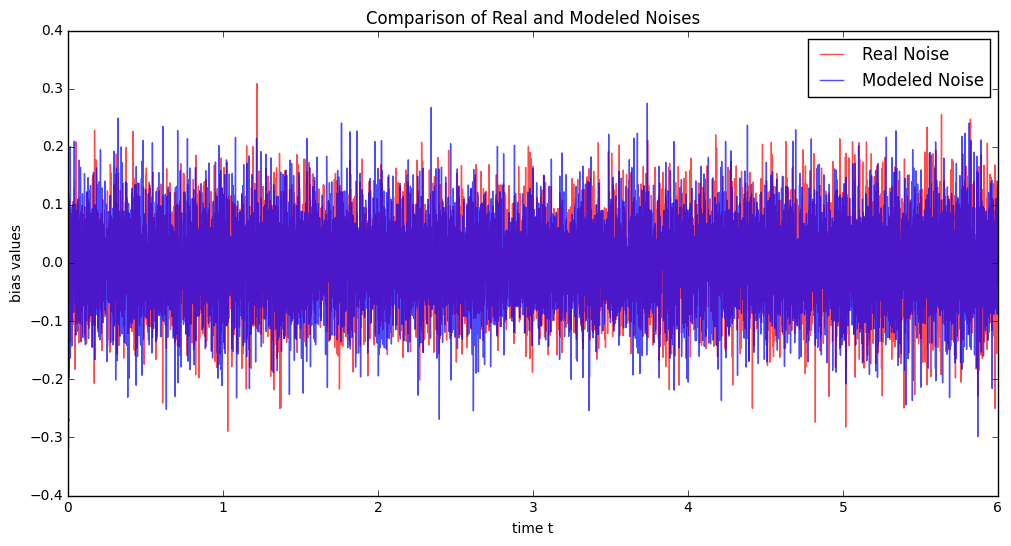

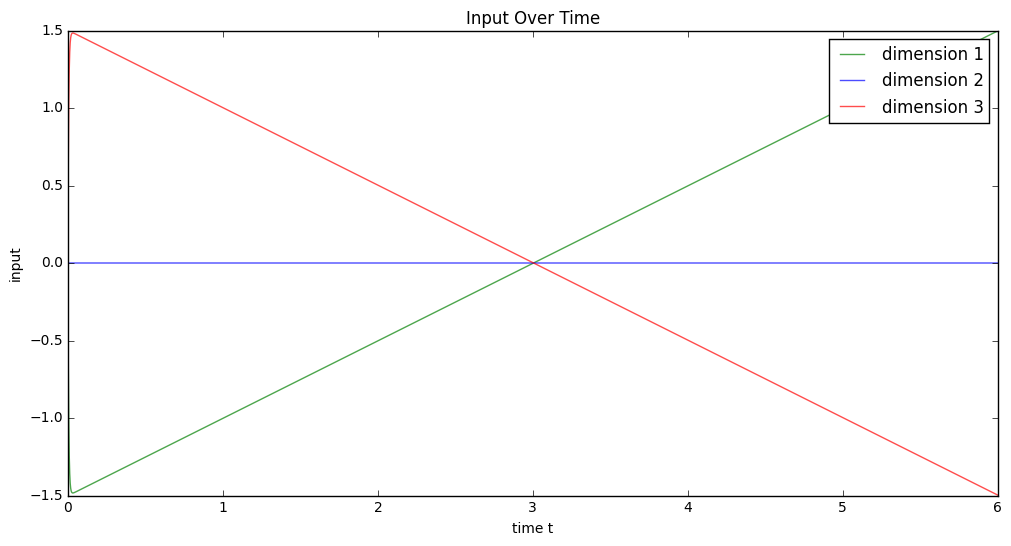

In [22]:
ensemble_config = {
    'n_neurons': 200,
    'dimensions': 3
}

def function(x):
    return x[0]**3 + x[1] + x[2]**2

components = [
    Mapping(lambda x: x[0]**3, 3, 1, [0], [0]),
    Mapping(lambda x: x[1],    3, 1, [1], [0]),
    Mapping(lambda x: 1/x[2],  3, 1, [2], [0])
]

connection = nengo.Connection(
    nengo.Node([1,1,1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

def input_func(t):
    return [ -1.5 + 3*t/6, 0, 1.5 - 3*t/6]

surrogate = SurrogateEnsemble(ensemble_config, connection, components, dt=0.001)
surrogate.build(noise_sampling_steps=3, seed=6) # sample noises at three input ranges
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title('Comparison of Real and Modeled Noises')
plt.xlabel('time t')
plt.ylabel('bias values')
plt.plot(surrogate.trange, surrogate.sim_noise_values[:,0], 'r', label="Real Noise", alpha=0.7)
plt.plot(surrogate.trange, surrogate.est_noise_values[:,0], 'b', label="Modeled Noise", alpha=0.7)
plt.legend()

plt.figure(figsize=(12,6))
plt.title('Input Over Time')
plt.xlabel('time t')
plt.ylabel('input')
plt.plot(surrogate.trange, surrogate.input[:,0], 'g', label="dimension 1", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,1], 'b', label="dimension 2", alpha=0.7)
plt.plot(surrogate.trange, surrogate.input[:,2], 'r', label="dimension 3", alpha=0.7)
plt.legend()


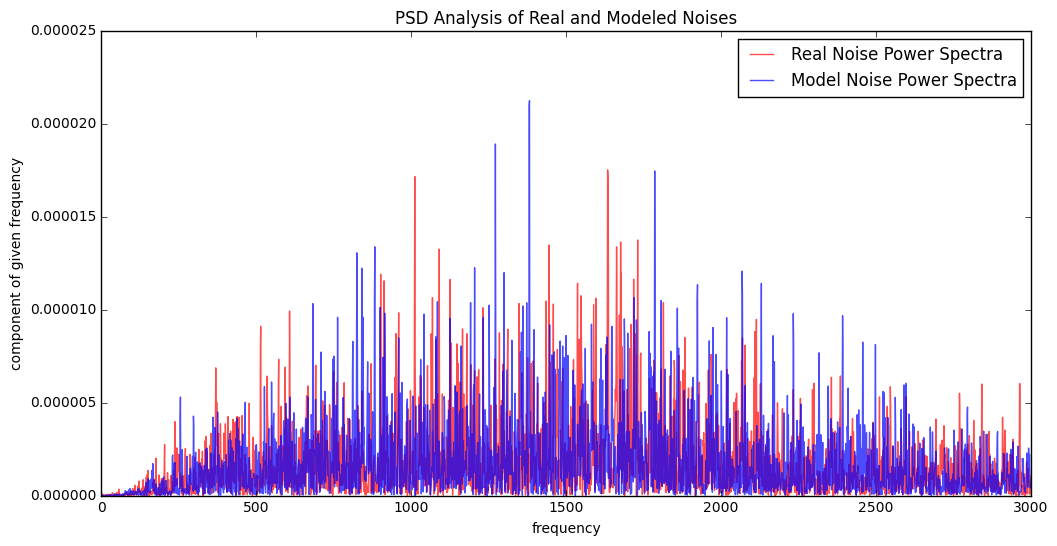

In [29]:
plt.figure(figsize=(12,6))
plt.title('PSD Analysis of Real and Modeled Noises')
plt.xlabel('frequency')
plt.ylabel('component of given frequency')
plt.plot(surrogate.spike_freqs[0], surrogate.spike_PSDs[0], 'r', label="Real Noise Power Spectra", alpha=0.7)
plt.plot(surrogate.model_freqs[0], surrogate.model_PSDs[0], 'b', label="Model Noise Power Spectra", alpha=0.7)
plt.legend()

### Putting It Together

* Sampling multiple noise samples takes more time
* Computing bias for each component takes more time 


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


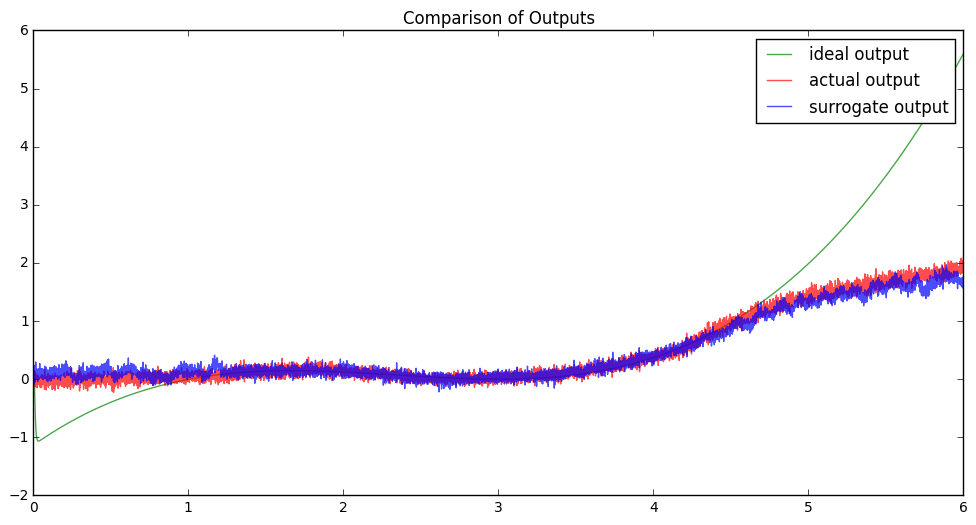

In [19]:
ensemble_config = {
    'n_neurons': 300,
    'dimensions': 3
}

def function(x):
    return x[0]**3 + x[1] + x[2]**2

components = [
    Mapping(lambda x: x[0]**3, 3, 1, [0], [0]),
    Mapping(lambda x: x[1],    3, 1, [1], [0]),
    Mapping(lambda x: x[2]**2,  3, 1, [2], [0])
]

connection = nengo.Connection(
    nengo.Node([1,1,1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

def input_func(t):
    return [ -1.5 + 3*t/6, 0, 1.5 - 3*t/6]

surrogate = SurrogateEnsemble(ensemble_config, connection, components, dt=0.001)
surrogate.build(noise_sampling_steps=3, seed=6) # sample noises at three input ranges
surrogate.test_performance(input_func, length=6, seed=6)

plt.figure(figsize=(12,6))
plt.title("Comparison of Outputs")
plt.plot(surrogate.trange, surrogate.ideal_output[:,0], 'g', label="ideal output", alpha=0.7)
plt.plot(surrogate.trange, surrogate.actual_output[:,0], 'r', label="actual output", alpha=0.7)
plt.plot(surrogate.trange, surrogate.surrogate_output[:,0], 'b', label="surrogate output", alpha=0.7)
plt.legend()

### Performance

In [20]:
ensemble_config = {
    'n_neurons': 300,
    'dimensions': 3
}

def function(x):
    return x[0]**3 + x[1] + x[2]**2

components = [
    Mapping(lambda x: x[0]**3, 3, 1, [0], [0]),
    Mapping(lambda x: x[1],    3, 1, [1], [0]),
    Mapping(lambda x: x[2]**2,  3, 1, [2], [0])
]

connection = nengo.Connection(
    nengo.Node([1,1,1], add_to_container=False),
    nengo.Node(size_in=1, add_to_container=False),
    synapse=0.005, function=function, add_to_container=False
)

def input_func(t):
    return [ -1.5 + 3*t/6, 0, 1.5 - 3*t/6]

import time
start = time.time()
sim, ens, out_conn, p_in, p_out = surrogate.build_network(
    input_func, surrogate.connection, surrogate.connection.function, 
    surrogate.connection.transform, surrogate.dt, 6
)
end = time.time()
full_simulation_build_time = end-start
print "==================="
print "full simulation build time: ", full_simulation_build_time
print "==================="

start = time.time()
surrogate.build(noise_sampling_steps=3, seed=6)
end = time.time()
population_mode_build_time = end-start
print "==================="
print "population mode build time:", population_mode_build_time
print "==================="


for i in [3,5,7,20]:
    print "\n==================="
    print "Simulation length = %d seconds" % i
    print "==================="
    
    start = time.time()
    sim.run(i)
    end = time.time()
    full_simulation_length = end - start
    print "\nfull simulation took: ", full_simulation_length
    print "Overall (build+simulation) time took: ", full_simulation_length + full_simulation_build_time

        
    out_shape = sim.data[p_out].shape
    start = time.time()
    surrogate.emulate(sim.data[p_in], out_shape)
    end = time.time()
    poplation_mode_simulation_length = end - start
    print "\npopulation mode simulation took: ", poplation_mode_simulation_length
    print "Overall (build+simulation) time took: ", poplation_mode_simulation_length + population_mode_build_time


Building finished in 0:00:01.                                                   
full simulation build time:  0.0700860023499
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


population mode build time: 2.12263703346

Simulation length = 3 seconds
Simulating finished in 0:00:01.                                                 

full simulation took:  0.780183076859
Overall (build+simulation) time took:  0.850269079208

population mode simulation took:  0.29017496109
Overall (build+simulation) time took:  2.41281199455

Simulation length = 5 seconds
Simulating finished in 0:00:02.                                                 

full simulation took:  1.48595786095
Overall (build+simulation) time took:  1.5560438633

population mode simulation took:  0.77605509758
Overall (build+simulation) time took:  2.89869213104

Simulation length = 7 seconds
Simulating finished in 0:00:03.                                                 

full simulation took:  2.02155303955
Overall (build+simulation) time took:  2.0916390419

population mode simulation took:  1.37188887596
Overall (build+simulation) time took:  3.49452590942

Simulation length = 20 seconds
Simulating 

**population mode simulation is faster when run on directly on terminal** instead of using jupytar. The following was the output when run on terminal.

```
===================
Simulation length = 20 seconds
===================
Simulating finished in 0:00:06.                                                 

full simulation took:  5.20197582245
Overall (build+simulation) time took:  5.24202179909

population mode simulation took:  1.7000579834
Overall (build+simulation) time took:  3.61904191971
```

### Performance Improvement

* Computing multiple bias components seem to be a bottle neck in output emulation. Similar experiment as above was run on the terminal, except the function was chosen to $f(x_1, x_2, x_3) = x_1^3$, which only has on component. 

```
===================
Simulation length = 20 seconds
===================
Simulating finished in 0:00:06.                                                 

full simulation took:  5.22485184669
Overall (build+simulation) time took:  5.9180867672

population mode simulation took:  0.876780033112
Overall (build+simulation) time took:  2.72845602036
```

* Computing multiple bias components should be parallizable

## Summary

### Accuracy
* Seems to work great for up to 2D and 3D ensembles
* In higher dimensions, bias estimation becomes less accurate 

### Performance
* Emulating output is generally fast.
    * Explore ways to parallize computation of bias components
   
   
## TODO
1. Investigate how bias can be better estimated in higher dimensions
    * we might need a radically new way
2. Optimize performance (i.e. parallize)



